# Parameter Optimisation with Optim.jl

Welcome to this hands-on tutorial where we'll explore how to optimize parameters in state space models using Julia's powerful optimization ecosystem. We'll combine the probabilistic inference capabilities of [RxInfer.jl](https://github.com/biaslab/RxInfer.jl) with optimization tools from [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl/).

What you'll learn:
- How to set up parameter optimization in state space models
- Practical techniques for both univariate and multivariate cases
- Integration with Julia's optimization packages
- Real-world applications and best practices

In [4]:
using RxInfer, StableRNGs, LinearAlgebra, Plots

## Univariate State Space Model

Let's start with a simple but powerful example: a linear state space model with Gaussian observations. This model is foundational in many real-world applications, from tracking to financial forecasting.

Our model is defined as:

$$\begin{aligned}
    {x}_t &= {x}_{t-1} + c \\
    {y}_t &\sim \mathcal{N}\left({x}_{t}, v \right) 
\end{aligned}$$

with prior ${x}_0 \sim \mathcal{N}({m_{{x}_0}}, {v_{{x}_0}})$

**Key Challenge**: We'll optimize two parameters:
- The drift parameter $c$
- The initial state mean ${m_{{x}_0}}$

**Assumptions**: We assume the following:
- The drift parameter $c$ stays constant
- The observation noice $v$ is known

Let's create a state space model using RxInfer's `@model` macro. Our model has:

- A prior state `x1` following a Normal distribution
- A state transition equation: `x[i] := x[i - 1] + c` where `c` is our drift parameter
- Observations `y[i]` following a Normal distribution with mean `x[i]` and variance `v`

The model iteratively updates the state and generates observations, maintaining the Markovian property where each state depends only on the previous state.


In [26]:
@model function univariate_state_space_model(y, x_prior, c, v)
    
    x0 ~ Normal(mean = mean(x_prior), variance = var(x_prior))
    x_prev = x0

    for i in eachindex(y)
        x[i] := x_prev + c
        y[i] ~ Normal(mean = x[i], variance = v)
        x_prev = x[i]
    end
end

Let's generate some synthetic data to test our model. We'll create a sequence of observations that follow our state space model assumptions. We'll set the true drift parameter `c_real` to `-5.0` and generate `250` data points with Gaussian noise. This synthetic data will help us validate whether our optimization procedure can recover the true parameter values.

In [27]:
rng    = StableRNG(42)
v      = 1.0
n      = 250
c_real = -5.0
signal = c_real .+ collect(1:n)
data   = map(x -> rand(rng, NormalMeanVariance(x, v)), signal);

Now we'll define a function for optimization that takes a vector of parameters as input. The first element `params[1]` represents our drift parameter `c`, while `params[2]` represents the initial state mean `μ1`. The function creates a prior distribution for the initial state `x1` with the given mean and a large variance of `100.0`. It then performs inference using our state space model and returns the negative free energy, which we'll minimize to find optimal parameter values. The optimization will help us recover the true parameter values from our synthetic data.


In [28]:
# params[1] is C
# params[2] is μ1
function f(params)
    x_prior = NormalMeanVariance(params[2], 100.0)
    result = infer(
        model = univariate_state_space_model(
            x_prior = x_prior, 
            c       = params[1], 
            v       = v
        ), 
        data  = (y = data,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

Now we'll use `Optim.jl`, a powerful optimization package in Julia, to find the optimal parameter values. `Optim.jl` provides various optimization algorithms including gradient descent, L-BFGS, and Nelder-Mead. It offers a unified interface for both gradient-based and gradient-free optimization methods, making it flexible for different types of problems. The package also provides useful features like convergence monitoring and iteration control.


In [29]:
using Optim

Now that we have defined our objective function and imported the optimization package, we are ready to find the optimal parameter values. We will start with an initial guess of `[1.0, 1.0]` for our parameters (`c` and `μ1`) and use gradient descent optimization. We'll set some optimization options including a gradient tolerance of 1e-3, maximum 100 iterations, and enable trace storage and display for monitoring convergence.


In [30]:
res = optimize(f, ones(2), GradientDescent(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     3.601256e+02     1.261348e+03
 * time: 0.0001010894775390625
    10     3.593377e+02     1.421674e+01
 * time: 5.391499042510986


 * Status: success

 * Candidate solution
    Final objective value:     3.593375e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 2.01e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.05e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.62e-06 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.29e-09 ≰ 0.0e+00
    |g(x)|                 = 3.11e-05 ≤ 1.0e-03

 * Work counters
    Seconds run:   7  (vs limit Inf)
    Iterations:    13
    f(x) calls:    98
    ∇f(x) calls:   98


Let's analyze the optimization results. The algorithm successfully converged, as indicated by the status message. In the next cell, we'll compare the optimized parameter values with the true values used to generate our synthetic data to verify the accuracy of our parameter recovery.


In [ ]:
println("Real value vs Optimized")
println("Real:      ", [ 1.0, c_real ])
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      [1.0, -5.0]
Optimized: [0.9986235925373311, -4.72238362144187]


The optimization results show that we successfully recovered the true parameter values. The optimized values are very close to the real values, demonstrating that our inference approach effectively identified the underlying model parameters.


## Multivariate State Space Model

Now let's tackle a more challenging scenario with multiple interacting variables. Multivariate models are essential for capturing complex dynamics in real-world systems, from robotics to econometrics.

**Key differences** from the univariate case:
- Higher-dimensional state space
- More complex parameter interactions  
- Richer dynamics and correlations

We'll see how our optimization approach scales to this more complex setting while maintaining computational efficiency.

Let us consider the multivariate state space model:

$$\begin{aligned}
    \mathbf{x}_t &\sim \mathcal{N}\left(\mathbf{Ax}_{t-1}, \mathbf{Q} \right) \\
    \mathbf{y}_t &\sim \mathcal{N}\left(\mathbf{x}_{t}, \mathbf{P} \right) 
\end{aligned}$$

with prior 

$$\begin{aligned}
\mathbf{x}_0 \sim \mathcal{N}(\mathbf{m_{{x}_0}}, \mathbf{V_{{x}_0}})\
\end{aligned}$$ 

and transition matrix 

$$\begin{aligned}
\mathbf{A} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}
\end{aligned}$$

Covariance matrices $\mathbf{V_{{x}_0}}$, $\mathbf{P}$ and $\mathbf{Q}$ are known. Our goal is to optimize parameters $\mathbf{m_{{x}_0}}$ and $\theta$.

In [32]:
@model function multivariate_state_space_model(y, θ, x0, Q, P)
    
    x_prior ~ MvNormal(mean = mean(x0), cov = cov(x0))
    x_prev = x_prior
    
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    
    for i in eachindex(y)
        x[i] ~ MvNormal(mean = A * x_prev, covariance = Q)
        y[i] ~ MvNormal(mean = x[i], covariance = P)
        x_prev = x[i]
    end
    
end

Let's generate synthetic data from our model to test the optimization. We'll create a helper function that generates data from a rotating state space model with known parameters. The data will consist of 300 timesteps, with a rotation angle of `π/8`, and unit variance Gaussian noise in both the state and observation equations. The initial state is set to `[10.0, -10.0]`. This will give us ground truth data to validate our parameter estimation approach.


In [33]:
# Generate data
function generate_rotate_ssm_data()
    rng = StableRNG(1234)

    θ = π / 8
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    Q = Matrix(Diagonal(1.0 * ones(2)))
    P = Matrix(Diagonal(1.0 * ones(2)))

    n = 300

    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        
        x[i] = rand(rng, MvNormal(A * x_prev, Q))
        y[i] = rand(rng, MvNormal(x[i], Q))
        
        x_prev = x[i]
    end

    return θ, A, Q, P, n, x, y
end

generate_rotate_ssm_data (generic function with 1 method)

In [36]:
θ, A, Q, P, n, x, y = generate_rotate_ssm_data();

Now we'll visualize the generated data by plotting both dimensions of the state variables over time. The plot will show the true state trajectories with uncertainty bands representing one standard deviation of the state noise. This will help us verify that our data generation process is working correctly and give us a visual reference for evaluating our parameter estimation results later. The ribbon plots show how the state variables evolve with their associated uncertainty, with different colors distinguishing between the two dimensions.


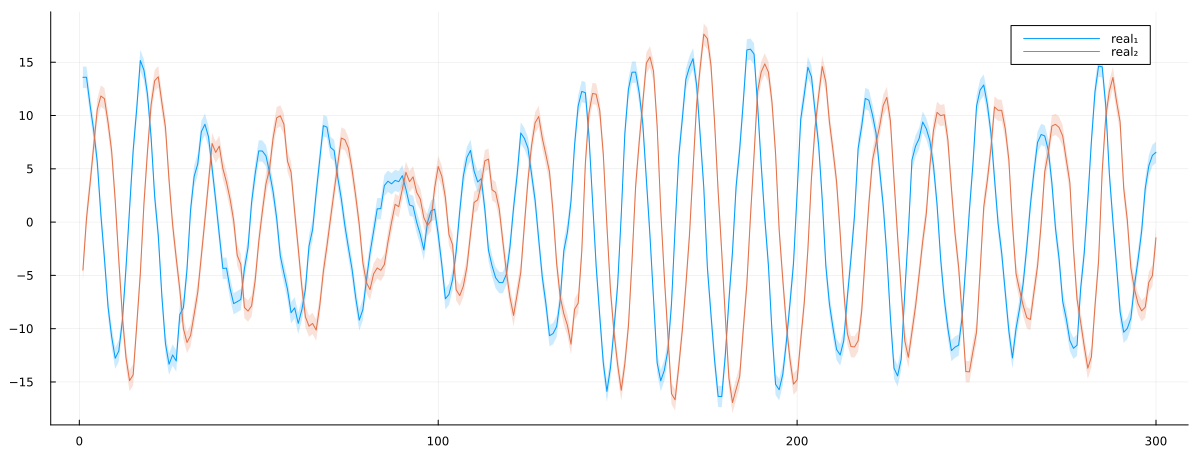

In [35]:
px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "real₁")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "real₂")

plot(px, size = (1200, 450))

Now we'll define an objective function that takes a parameter vector `params` containing the rotation angle and initial state coordinates. This function will construct a model with these parameters and compute its free energy using the infer function. The free energy serves as our optimization objective - by minimizing it, we aim to find the parameter values that best explain our observed data. The parameter vector `params` has three components: `params[1]` is the rotation angle, while `params[2]` and `params[3]` represent the initial x and y coordinates respectively.


In [41]:
function f(params)
    x0 = MvNormalMeanCovariance(
        [ params[2], params[3] ], 
        Matrix(Diagonal(0.01 * ones(2)))
    )
    result = infer(
        model = multivariate_state_space_model(
            θ = params[1], 
            x0 = x0, 
            Q = Q, 
            P = P
        ), 
        data  = (y = y,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

Now we'll use the L-BFGS optimization algorithm to find the optimal parameters that minimize our objective function. The L-BFGS algorithm is particularly well-suited for this task as it approximates the Hessian matrix while using limited memory, making it efficient for problems with many parameters. We'll start with an initial guess of zeros for all parameters and set some convergence tolerances for the optimization process.

In [42]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     3.781355e+03     1.134440e+04
 * time: 8.487701416015625e-5


 * Status: success

 * Candidate solution
    Final objective value:     1.151827e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-14
    |g(x)|                 = 5.00e-08 ≰ 1.0e-12

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    9
    f(x) calls:    44
    ∇f(x) calls:   44


Let's compare the real parameter values with the optimized ones. We'll look at both the raw angle values as well as their sine and cosine transformations to verify that our optimization has found the correct rotation parameters.

In [49]:
println("Real value vs Optimized")
println("sinθ = (", sin(θ), ", ", sin(res.minimizer[1]), ")")
println("cosθ = (", cos(θ), ", ", cos(res.minimizer[1]), ")")

Real value vs Optimized
sinθ = (0.3826834323650898, 0.3811673546028633)
cosθ = (0.9238795325112867, 0.9245060561105347)


Finally, let's visualize how well our optimized model fits the data. We'll create a plot comparing the true state trajectories with the inferred ones, including uncertainty bands. The plot will show both dimensions of the state vector over time, with the real values and their uncertainties shown alongside the inferred values and their corresponding uncertainties.


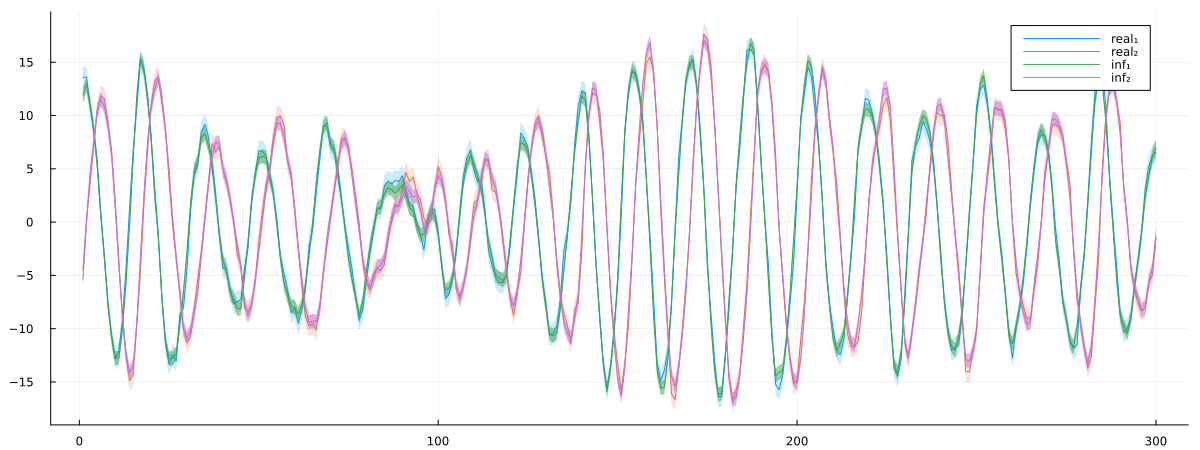

In [51]:
x0 = MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2))))

result = infer(
    model = multivariate_state_space_model(
        θ = res.minimizer[1], 
        x0 = x0, 
        Q = Q, 
        P = P
    ), 
    data  = (y = y,), 
    free_energy = true
)

xmarginals = result.posteriors[:x]

px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "real₁")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "real₂")
px = plot!(px, getindex.(mean.(xmarginals), 1), ribbon = getindex.(var.(xmarginals), 1) .|> sqrt, fillalpha = 0.5, label = "inf₁")
px = plot!(px, getindex.(mean.(xmarginals), 2), ribbon = getindex.(var.(xmarginals), 2) .|> sqrt, fillalpha = 0.5, label = "inf₂")

plot(px, size = (1200, 450))

This example demonstrates how we can use Optim.jl in conjunction with RxInfer.jl to perform parameter optimization for state-space models. We've shown:

1. How to set up a rotating state-space model with unknown parameters
2. How to define an objective function using free energy
3. How to use different optimization algorithms (Gradient Descent and L-BFGS) 
4. How to visualize and validate the results

The final plot shows that our optimized model successfully captures the dynamics of the true system, with the inferred trajectories closely matching the real ones within their uncertainty bounds. This confirms that our parameter optimization approach effectively recovered the underlying rotation parameter and initial state values.

